<h1>Introduction</h1>
<h2>CRVAE t-SNE for Unsupervised Feature Learning: Image Classification of Flower </h2>
<p>
This project explores the utilization of machine learning (ML) strategies for unsupervised feature learning and classification of flower images. Leveraging the capabilities of a Convolutional ResNet Variational AutoEncoder (CRVAE) combined with t-Distributed Stochastic Neighbour Embedding (t-SNE) clustering, we aim to derive meaningful and separable feature representations of flower datasets.</p>
<p>The dataset contains 2,669 unlabelled images of flowers (and junk images) that fit into one 5 classes in the training set and the test set has 1,000 labelled images, 200 from each category.
</p>
<p>Example of train data:
<table>
    <td><img src="./pics_for_notebook/1.jpg" alt="1" width="150" height="150"></td>
    <td><img src="./pics_for_notebook/2.jpg" alt="2" width="150" height="150"></td>
    <td><img src="./pics_for_notebook/3.jpg" alt="3" width="150" height="150"></td>
    <td><img src="./pics_for_notebook/4.jpg" alt="4" width="150" height="150"></td>
</table>
</p>

<h2>AutoEncoders</h2>
<p>
Sources:
https://paperswithcode.com/method/autoencoder ; https://arxiv.org/pdf/2003.05991.pdf
</p><p>
An autoencoder is a bottleneck architecture that turns a high-dimensional input into a latent low-dimensional code (encoder), and then performs a reconstruction of the input with this latent code (the decoder). Their main purpose is learning in an unsupervised manner an “informative” representation of the data that can be used for various implications such as clustering.
<img src="./pics_for_notebook/autoencoder.png" alt="4" width="300" height="300"></p>
<h2>VAE</h2>
<p>
Sources:
https://www.techtarget.com/searchenterpriseai/definition/variational-autoencoder-VAE
</p><p>
A variational autoencoder (VAE) is a generative AI algorithm that uses deep learning to generate new content, detect anomalies and remove noise. 
</p>
<h2>ResNet</h2>
<p>
Sources:
https://par.nsf.gov/servlets/purl/10225365 ; https://github.com/JayPatwardhan/ResNet-PyTorch/tree/master
</p><p>
Efficient modeling of high-dimensional data requires extracting only relevant dimensions through feature learning. The advantage of RAE and C-RAE is that it enables the user to add residual connections for increased network capacity without incurring the cost of degradation for unsupervised feature learning compared to standard AEs.
</p>
<p>The resnetblock: <img src="./pics_for_notebook/resnetblock.png" alt="4" width="250" height="250"></p>
<h2>t-SNE</h2>
<p>
Sources:
https://www.datacamp.com/tutorial/introduction-t-sne ; https://www.kaggle.com/code/rohitgr/autoencoders-tsne
</p><p>
t-SNE is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. The t-SNE algorithm finds the similarity measure between pairs of instances in higher and lower dimensional space. After that, it tries to optimize two similarity measures. 
</p>

In [1]:
# for the model
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

# for progress bar
from tqdm import tqdm as tq

#for clustring 
from sklearn.manifold import TSNE

#for ploting
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
def imshow_reconst(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 100
BATCH_SIZE = 4
IMG_SIZE = 128
H_DIM = 5
PATH = r'.\Wieghts'

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize the images to IMG_SIZExIMG_SIZE
    transforms.ToTensor(),  # Convert images to Tensor
])

unlabeled_data_path = r'C:\Users\shirl\Documents\imagegene_flowers\DS_dataset'
dataset = datasets.ImageFolder(root=unlabeled_data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
# The Model
class ResNetBlockEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(ResNetBlockEncoder, self).__init__()
        
        self.downsample = downsample
        self.relu = nn.LeakyReLU()
        # --------- conv 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # --------- conv 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        if self.downsample is not None:
            x = self.downsample(x)
            
        layer1 = self.conv1(x)
        layer1 = self.bn1(layer1)
        layer1 = self.relu(layer1)

        layer2 = self.conv2(layer1)
        layer2 = self.bn2(layer2)
        layer2 = self.relu(layer2)
        layer2 = self.conv2(layer1)
        layer2 = self.bn2(layer2)
        layer2 = self.relu(layer2)

        out_layer = torch.add(layer1, layer2)
        out_layer = self.relu(out_layer)

        return out_layer
    
class ResNetBlockDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride, upsample=None):
        super(ResNetBlockDecoder, self).__init__()
        
        self.upsample = upsample
        self.relu = nn.LeakyReLU()
        # --------- t-conv 1
        self.tconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # --------- t-conv 2
        self.tconv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.upsample = upsample
        
    def forward(self, x):
        if self.upsample is not None:
            x = self.upsample(x)
            
        layer1 = self.tconv1(x)
        layer1 = self.bn1(layer1)
        layer1 = self.relu(layer1)

        layer2 = self.tconv2(layer1)
        layer2 = self.bn2(layer2)
        layer2 = self.relu(layer2)
        layer2 = self.tconv2(layer1)
        layer2 = self.bn2(layer2)
        layer2 = self.relu(layer2)

        out_layer = torch.add(layer1, layer2)
        out_layer = self.relu(out_layer)

        return out_layer

class CRVAE(nn.Module):
    def __init__(self, img_size, stride, latent_dim):
        super(CRVAE, self).__init__()
        
        self.img_size = img_size
        linear_layer = int((self.img_size - 3 + 2)/stride) +1  #( (I-K+2P)/(S) + 1)
        self.linear_layer = int(linear_layer / 4) # beacuse MaxPooling
        
        self.relu = nn.LeakyReLU()
        
        # encoder
        self.resnet1 = ResNetBlockEncoder(in_channels=3, out_channels=16, stride=stride)
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.resnet2 = ResNetBlockEncoder(in_channels=16, out_channels=32, stride=stride)
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.linear1 = nn.Linear(self.linear_layer*self.linear_layer*32, int(self.linear_layer*self.linear_layer*32/16))
        self.linear3 = nn.Linear(int(self.linear_layer*self.linear_layer*32/16), int(self.linear_layer*self.linear_layer*32/64))
        self.fc_mu = nn.Linear(int(self.linear_layer*self.linear_layer*32/64), latent_dim)
        self.fc_var = nn.Linear(int(self.linear_layer*self.linear_layer*32/64), latent_dim)
        
        # decoder
        self.unlinear0 = nn.Linear(latent_dim, int(self.linear_layer*self.linear_layer*32/64))
        self.unlinear1 = nn.Linear(int(self.linear_layer*self.linear_layer*32/64), int(self.linear_layer*self.linear_layer*32/16))
        self.unlinear3 = nn.Linear(int(self.linear_layer*self.linear_layer*32/16) , self.linear_layer*self.linear_layer*32)
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2)
        self.unresnet2 = ResNetBlockDecoder(in_channels=32, out_channels=16, stride=1)
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2)
        self.unresnet1 = ResNetBlockDecoder(in_channels=16, out_channels=3, stride=1)

    def encode(self, x):
        self.batch_size = x.size(0)
        x = self.resnet1(x)
        x, self.indices1 = self.pool1(x)
        x = self.relu(x)
        
        x = self.resnet2(x)
        x, self.indices2 = self.pool2(x)
        x = self.relu(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        
        z = self.unlinear0(z)
        z = self.relu(z)
        
        z = self.unlinear1(z)
        z = self.relu(z)
        
        z = self.unlinear3(z)
        z = self.relu(z)

        z = z.view(self.batch_size, 32, self.linear_layer, self.linear_layer)

        z = self.unpool2(z, self.indices2)
        z = self.unresnet2(z)
        z = self.relu(z)
        
        z = self.unpool1(z, self.indices1)    
        z = self.unresnet1(z)
        
        return torch.sigmoid(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [8]:
def extract_features(dataloader, encoder):
    features = []
    with torch.no_grad():
        for data, _ in dataloader:
            mu, logvar = encoder(data.to(device))
            features.append(mu.cpu())

    # Concatenate all features into a single tensor
    features = torch.cat(features, dim=0)
    return features

def showResults(model):
    # Graph
    test_data_path = r'.\DS_dataset\test'
    test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_features = extract_features(test_dataloader, model.encode)
    test_features = test_features.numpy()
    true_labels = [label for _, label in test_dataset]
    tsne = TSNE(n_components=2)
    reduced_features = tsne.fit_transform(test_features)
    plt.figure(figsize=(12, 6))

    # Plot reduced features in 2D, colored by true class labels
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=true_labels, palette="bright")
    plt.title('Train Labels')
    plt.show()

    data, _ = next(iter(train_loader))
    data_reconst, mu, sigma = model(data)
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        imshow(data[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    for i in range(4):
        plt.subplot(2,2, i + 1)
        imshow_reconst(data_reconst[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
def train(num_epochs, model, optimizer, scheduler):
    for epoch in range(num_epochs):
        # progress bar
        print("epoch number:", epoch+1)
        loop = tq(enumerate(train_loader))
        for i, (feature, label) in loop:
            # Forward pass
            feature = feature.to(device)
            feature_reconst, mu, log_var = model(feature)

            #clac loss
            rec_loss = F.mse_loss(feature_reconst, feature)
            kl_div = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim=0)
            total_loss = rec_loss + kl_div.mean()
            
            # Backprop and optimize
            optimizer.zero_grad()
            total_loss.backward()
            
            #optimizer            
            optimizer.step()
            loop.set_postfix(loss=total_loss.item())     
            
            
        # Update the learning rate
        scheduler.step()            
       

In [11]:
initial_lr = 0.001

conv_rvae = CRVAE(img_size=IMG_SIZE, stride=1, latent_dim=H_DIM).to(device)
optimizer = optim.Adam(conv_rvae.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
train(NUM_EPOCHS, conv_rvae, optimizer, scheduler)

epoch number: 1


2it [00:05,  2.64s/it, loss=5.45e+10]


KeyboardInterrupt: 

In [ ]:
showResults(conv_rvae)

C:\Users\shirl\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\shirl\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


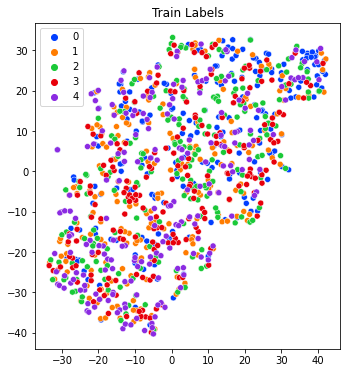

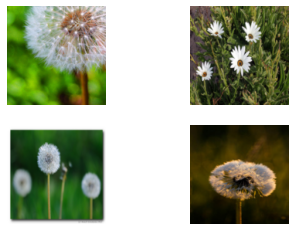

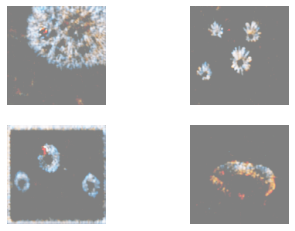

In [12]:
# for seeing results with the weights achived after 20 epochs
conv_rvae = CRVAE(img_size=IMG_SIZE, stride=1, latent_dim=H_DIM).to(device)
conv_rvae.load_state_dict(torch.load(PATH))
conv_rvae.eval()
showResults(conv_rvae)